# House Prices - Advanced Regression Techniques

In [11]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
        pass
warnings.warn = ignore_warn
# For some statistics
from scipy import stats
from scipy.stats import skew, norm

## Import Datasets

In [12]:
# Import datasets into pandas dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

**Investigate Datasets**

In [13]:
# Display first 5 rows of training dataset
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:
# Display first 5 rows of test dataset
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [15]:
# Check number of features and number of samples
print(f"Train dataset shape is: {train.shape}")
print(f"Test dataset shape is: {test.shape}")

# Save ID columns
train_ID = train['Id']
test_ID = test['Id']

# Drop ID column as it's unnecessary for prediction
test.drop('Id', axis = 1, inplace= True)
train.drop('Id', axis = 1, inplace= True)

# Check again data shapes
print('\n')
print(f"Train dataset shape is: {train.shape}")
print(f"Test dataset shape is: {test.shape}")

Train dataset shape is: (1460, 81)
Test dataset shape is: (1459, 80)


Train dataset shape is: (1460, 80)
Test dataset shape is: (1459, 79)


## EDA and Data Processing

**Checking for Outliers**

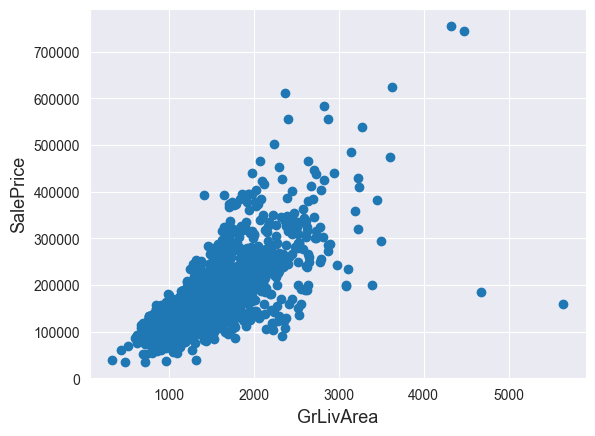

In [16]:
# Scatterplot of SalePrice and GrLivArea
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

There are two points at the bottom right of the scatterplot that shows high GrLivArea but relatively low SalePrice. These values stand out significantly as huge outliers, so we can remove them from thee dataset

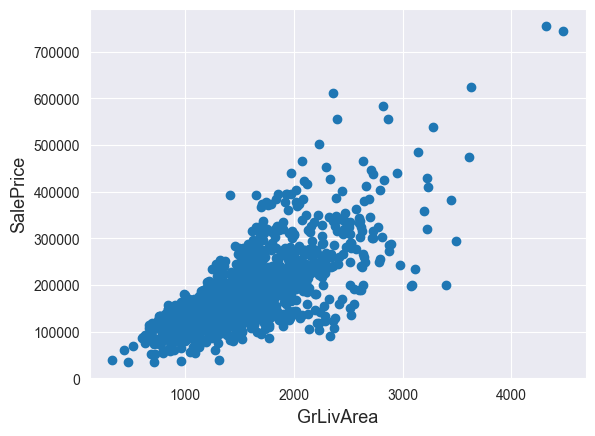

In [17]:
# Delete outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Plot again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Note :

Removing outliers isn't foolproof. We opted to eliminate two specific outliers due to their exceptionally large areas for significantly low prices. It's likely that there are more outliers in our training data. Yet, removing all of them could negativelyy impact our models if there are outliers in the test data as well. Hence, instead of removing all outliers, we'll focus on making some of our models resilient to them. You can find more details in the modeling section of this notebook.

## Target Variable

Target variable is **SalePrice**. We will conduct an analysis specifically on this variable

mu: 180932.92
sigma: 79467.79


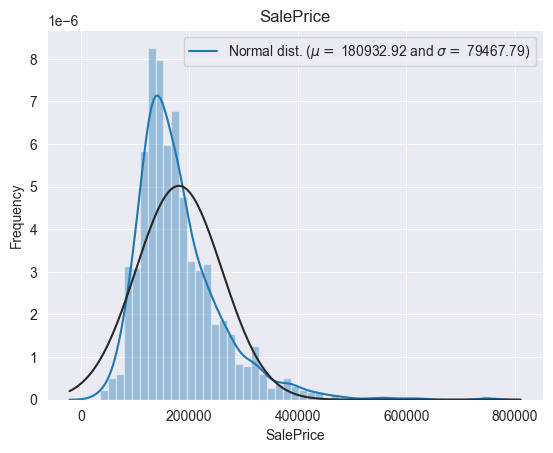

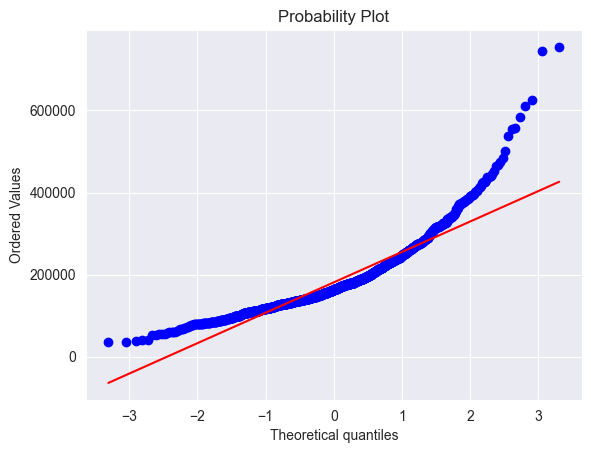

In [18]:
sns.distplot(train['SalePrice'], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print("mu: {:.2f}\nsigma: {:.2f}".format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
           loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice')

# QQ-Plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

SalePrice distribution is right skewed as seen in the Distribution plot and the QQ plot. As linear models usually assume a normally distributed data, we will need to transform the SalePrice variable and make it more normally distributed.

**Log-Transformation of Target Variable**

mu: 12.02 and sigma: 0.40


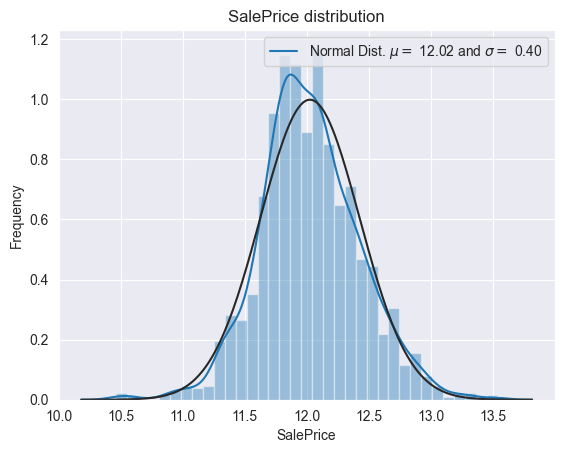

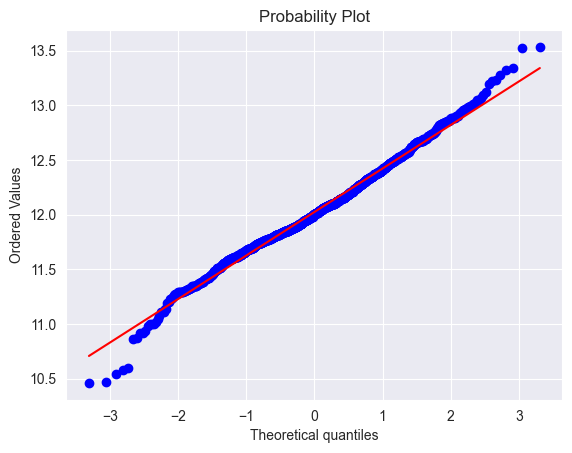

In [19]:
# Transform SalePrice using log(1+x)
train['SalePrice'] = np.log1p(train['SalePrice'])

# Check the new distribution
sns.distplot(train['SalePrice'], fit = norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print("mu: {:.2f} and sigma: {:.2f}".format(mu, sigma))

# Plot new distribution
plt.legend(["Normal Dist. $\mu=$ {:.2f} and $\sigma=$ {:.2f}".format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Get new QQ plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


The skew now seems corrected and the target variable seems more normally distributed

## Feature Engineering

Concatenate train and test dataset into one dataframe for convenience

In [20]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis = 1, inplace= True)
print("all_data size is: {}".format(all_data.shape))


all_data size is: (2917, 79)


### Missing Data

In [21]:
# Represent missing data as percentage missing
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
MasVnrType,60.541652
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

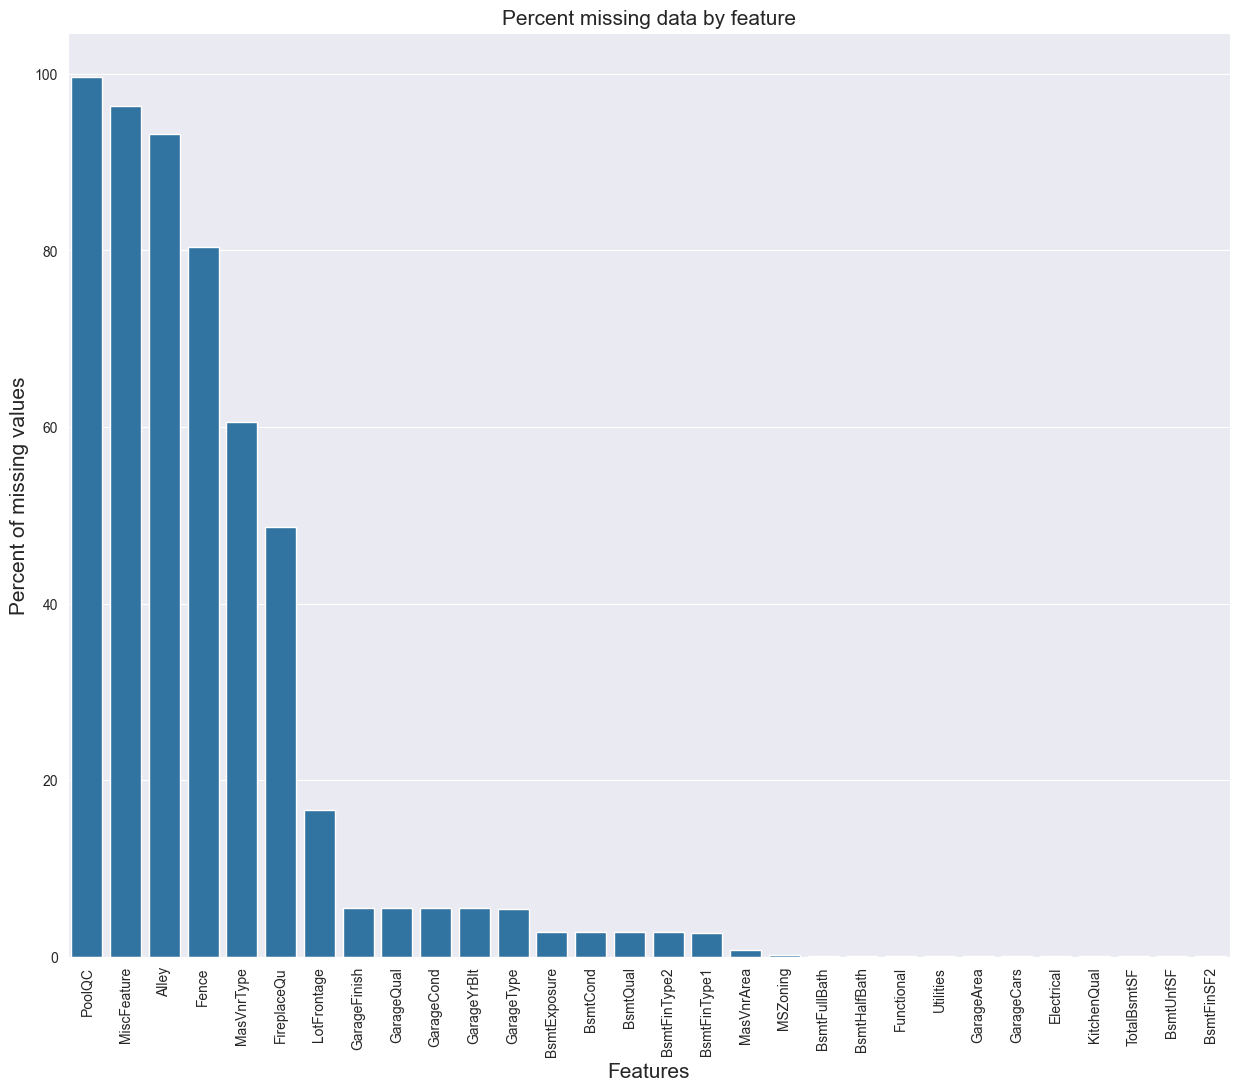

In [22]:
# Plot missing ratio as barplot
fig, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

### Data Correlation

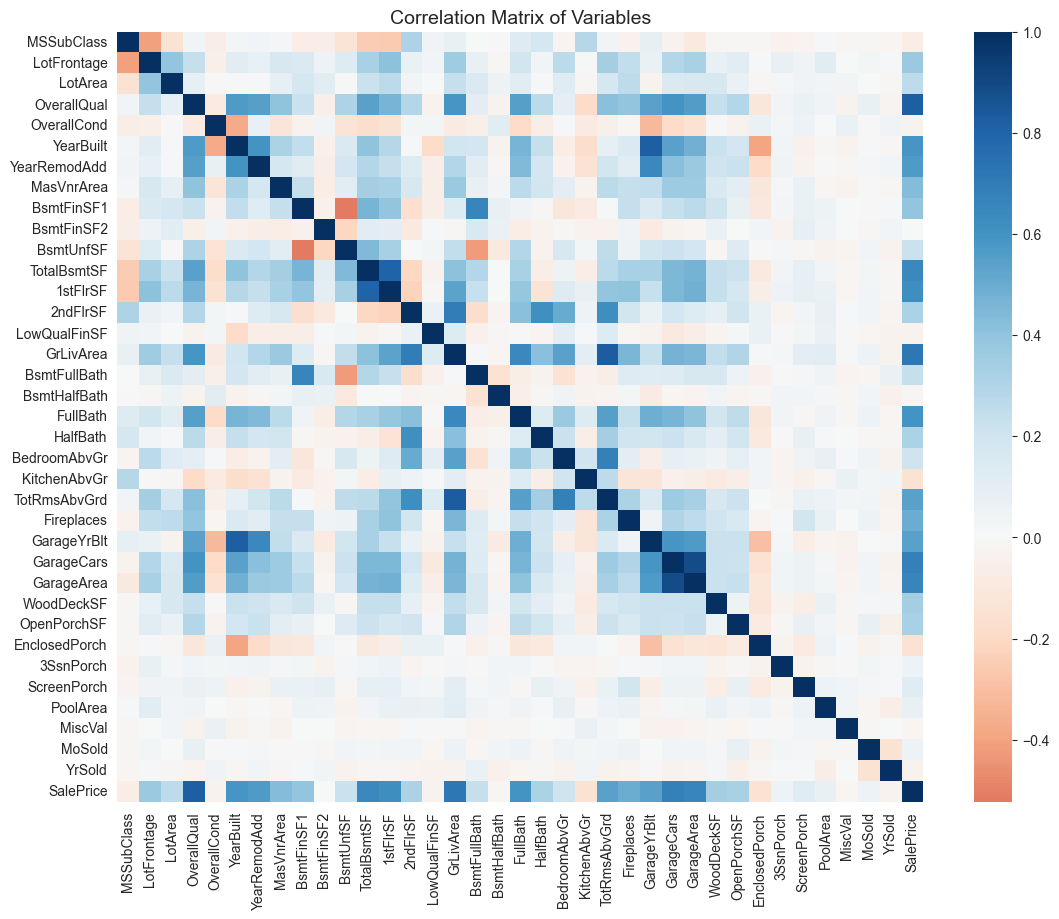

In [23]:
# Correlation map to see how features are correlated with SalePrice
plt.figure(figsize=(13,10))
corr_heatmap = train.corr(numeric_only=True)
sns.heatmap(corr_heatmap, annot=False, annot_kws={'size': 10}, cmap='RdBu', center=0)
plt.title('Correlation Matrix of Variables', fontsize = 14)
sns.set(rc = {'figure.dpi': 800})
plt.show()


### Imputing Missing Values

We impute them by proceeding sequentially through features with missing values

- **PoolQC**: Data description says NA for no pool. Makes sense given the ratio of missing values (>99%) and majority of all houses have no pools in general

In [24]:
# Fills NA value with none
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

- **MiscFeature**: Data description says NA means "no misc feature"

In [25]:
# Fill NA value with none
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

- **Alley**: Data description say NA means "No alley access"

In [26]:
all_data['Alley'] = all_data['Alley'].fillna('None')

- **Fence**: Data description says NA means "no fence"

In [27]:
all_data['Fence'] = all_data['Fence'].fillna('None')

- **FireplaceQu**: Data description says NA means "No Fireplace"

In [28]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

- **LotFrontage**: Linear feet of street connected to the property. Since the area of street connected to the house property most likely has a similar area to other houses in the neighbourhood, we can fill in the **missing values with the median LotFrontage of the neighbourhood**

In [29]:
# Group by neighborhood and fill in missing values by the median LotFrontage of respective neighborhood
# x in lambda function represents LotFrontage for a specific neighborhood
all_data['LotFrontage'] = all_data.groupby("Neighborhood")['LotFrontage'].transform(lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond**: Fill missing values with none as NA means no garage

In [30]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[str(col)] = all_data[str(col)].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars**: Replace missing values with 0, since no garage means 0 area and 0 cars

In [31]:
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath**: Missing values are likely to have zero for having no basement

In [32]:
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    all_data[col] = all_data[col].fillna(0)

**BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2**: Missing values mean that there is no basement

In [33]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    all_data[col] = all_data[col].fillna('None')

**MasVnrType and MasVnrArea**: NaN most likely means no masonry veneer for these houses. We can fill 0 for area and None for type

In [34]:
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')

**MSZoning**: 'RL' is by far the most common value and so we can fill missing values with RL

In [35]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.

In [36]:
all_data = all_data.drop('Utilities', axis=1)

**Functional**: Data description says NA means typical

In [37]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

**Electrical**: Only has one NA value, we can fill it with the most common value

In [38]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

**KitchenQual**: Only has one NA value, we can fill it with the most common value

In [39]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

**Exterior1st and Exterior2nd**: Only has one NA value, we can fill it with the most common value

In [40]:
for col in ['Exterior1st', 'Exterior2nd']:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

**SaleType**: Only has one NA value, we can fill it with the most common value

In [41]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

Check for remaining missing values in dataset

In [42]:
# Represent missing data as percentage missing
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head(20)

,Missing Ratio


*No remaining missing values in dataset*

**Transfroming some numerical variables that are really categorical**

In [43]:
# MSSubClass = The Building Class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# OverallCond - Ordinal variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Year and Month sold should be categorical variables 
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)

**Label Encoding some categorical variables that may contain information in their ordering set** 

Label Encoding coverts categorical variables into numbers

In [44]:
from sklearn.preprocessing import LabelEncoder
columns = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']
# Process these columns using LabelEncoder
for cols in columns:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[cols].values))
    all_data[cols] = lbl.transform(list(all_data[cols].values))

# Shape
print('Shape of all_data: {}'.format(all_data.shape))

Shape of all_data: (2917, 78)


**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of the basement, first and second floors of each house

In [45]:
# Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**Skewed features**

In [46]:
numeric_features = all_data.dtypes[all_data.dtypes != 'object'].index

# Check the skew of all numerical features and order descending
skewed_feats = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("Skew in numerical features:\n")
skewness = pd.DataFrame({'skew': skewed_feats})
skewness.head(10)

Skew in numerical features:



,skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


**Box-Cox Transformation of (highly) skewed features**

We utilize the `scipy` function `boxcox1p` to compute the Box-Cox transformation of **\\(1 + x\\)**.

Note that by setting \\(\lambda = 0\\), we're opting for a transformation akin to `np.log1p()` used earlier for the target variable.

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [47]:
skewness = skewness[abs(skewness['skew'])>0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 36 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

Applies one hot encoding of categorical features

In [48]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

### Get the new train and test datasets

In [49]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [50]:
train.head(5)

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,5.831328,19.212182,0.730463,1,3,0.0,7,4,2003,...,False,False,False,True,False,False,False,False,True,False
1,5,6.221214,19.712205,0.730463,1,3,0.0,6,7,1976,...,False,False,False,True,False,False,False,False,True,False
2,10,5.914940,20.347241,0.730463,1,0,0.0,7,4,2001,...,False,False,False,True,False,False,False,False,True,False
3,11,5.684507,19.691553,0.730463,1,0,0.0,7,4,1915,...,False,False,False,True,True,False,False,False,False,False
4,10,6.314735,21.325160,0.730463,1,0,0.0,8,4,2000,...,False,False,False,True,False,False,False,False,True,False


In [51]:
test.head(5)

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1458,5,6.221214,20.479373,0.730463,1,3,0.0,5,5,1961,...,False,False,False,True,False,False,False,False,True,False
1459,5,6.244956,21.327220,0.730463,1,0,0.0,6,5,1958,...,False,False,False,True,False,False,False,False,True,False
1460,10,6.073289,21.196905,0.730463,1,0,0.0,5,4,1997,...,False,False,False,True,False,False,False,False,True,False
1461,10,6.172972,19.865444,0.730463,1,0,0.0,6,5,1998,...,False,False,False,True,False,False,False,False,True,False
1462,0,5.093857,17.257255,0.730463,1,0,0.0,8,4,1992,...,False,False,False,True,False,False,False,False,True,False


## Modelling

**Importing Libraries**

In [96]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import RegressorMixin, BaseEstimator, TransformerMixin, clone
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

**Define a cross-validation strategy**

We use the cross_val_score function of sklearn. However, this function does not have a shuffle attribute, so we add this feature

In [53]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

### Base Models

- **LASSO Regression**:

This model may be very sensitive to outliers. So we need to make it more robust using the **RobustScaler()** method

In [54]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

- **Elastic Net Regression**:

Again made to be robust with outliers

In [55]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))

- **Kernel Ridge Regression**:

In [56]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression**:

With huber loss that makes it robust to outliers

In [57]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

- **XGBoost**:

In [58]:
model_xgb = xgb.XGBRegressor(colsample_bytree = 0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread=-1)

**LightGBM**:

In [59]:
model_lgb = lgb.LGBMRegressor(objective="regression", num_leaves = 5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq = 5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

### Base Model Scores

Lets see how these models perform on the data by evaluating the cross-validation rmsle error

In [60]:
score = rmsle_cv(lasso)
print("Lasso regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso regression score: 0.1103 (0.0072)



In [61]:
score = rmsle_cv(ENet)
print("Elastic Net regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Elastic Net regression score: 0.1103 (0.0072)



In [62]:
score = rmsle_cv(KRR)
print("Kernel Ridge Regression score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Kernel Ridge Regression score: 0.1780 (0.0067)


In [63]:
score = rmsle_cv(GBoost)
print("Gradient Boost Regression score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Gradient Boost Regression score: 0.1167 (0.0083)


In [64]:
score = rmsle_cv(model_xgb)
print("XG Boost Score: {:.4f}, ({:.4f})".format(score.mean(), score.std()))

XG Boost Score: 0.1166, (0.0065)


In [65]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_le

## Stacking Models

### Simplest stacking approach: Averaging Base Models

We begin by using the simplest approach which is to average all the base models. We build a new class to extend sci-kit learn with our model and leverage encapsulation and code resuse (inheritance)

**Average base models class**

In [68]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    """
    We define clones of the models to fit the data in
    X - features
    y - Target Variable (SalePrice)
    """
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)

        return self
    
    """ 
    Use each model to predict the target variable (SalePrice)
    Then get the average SalePrice between all the models
    """
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

        

**Averaged Base Models Score**

In [85]:
averaged_models = AveragingModels(models = (lasso, ENet, KRR, GBoost))

score = rmsle_cv(averaged_models)
print("Averaged Base Models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Averaged Base Models score: 0.1132 (0.0080)


Results are slightly better than the individual base models

### More Complex approach: Adding a Meta-model

In this approach, we add a meta-model on the averaged base models and use the out-of-fold predictions of these base models to train our meta-model

The procedure, for the training part, is described below:

1. Split the training set into two disjoint sets (**train** and **holdout**)
2. Train several base models on the first part (**train**)
3. Test these base models on the second part (**holdout**)
4. Use the predictions from 3) (called out-of-fold predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called a **meta-model**

The first 3 steps are done iteratively. If we take for example a 5-fold stacking, we first split the training data into 5 folds. Then we will do 5 iterations of this. In each iteration, we train every base model on the 4 folds and predict on the remaining fold (holdout fold).

After 5 iterations, the model will have used the entire data to get out-of-fold predictions that we will then use as a new feature to train our meta-model in step 4.

For the prediction part, we average the predictions of all base models on the test data and use them as **meta-features** on which the final predicition is done with the meta-model.

![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

![kaz](https://raw.githubusercontent.com/datasciblog/datasciblog.github.io/master/_posts/images/2017-06-15-stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/2.gif)

Gif taken from [KazAnova's interview](https://datasciblog.github.io/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/)

In this gif, the base models are algoritm 0, 1 and 2 and the meta-model is algorithm 3. The entire training dataset is A+B (target variable y known) which we can split into train part (A) and holdout part (B). C is the test dataset.

B1 (the prediction results of the holdout set) is the new feature used to train the meta-model. C1 (the prediction results of the test dataset) is the meta-feature on which the final prediction is done.

**Stacking Averaged Models Class**

In [90]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We fit the data into clones of the original models
    def fit(self, X, y):
        """ 
        base_models_ : lists of empty lists
        meta_model_ : clone of meta model that is untrained
        """
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits = self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        
        # Store out of fold predictions in matrix of size 
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            # Train each model
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                # Insert model into base_models_
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                # Record out of fold predictions
                # i is model count
                out_of_fold_predictions[holdout_index, i] = y_pred

        # now train the cloned meta-model on the out of fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    # Do prediction on each of the base models using the test data and average predictions
    # This average will act as a meta-feature for the final prediction which is done by the meta-model
    def predict(self, X):
        """ 
        meta_features: 2D array
            Each row corresponds to an instance of X
            Each column corresponds to the mean predictions from each base model
        """
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

**Adding Meta-Model Score**

We add a meta-model to the previous averaged model to compare these two approaches

In [132]:
stacked_averaged_models = StackingAveragedModels(base_models=(ENet, KRR, GBoost), meta_model=lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacked average models score with meta-model: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacked average models score with meta-model: 0.1078 (0.0074)


Score is much better when meta-model is added

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost** and **LightGBM** to the **StackedRegressor** (averaged models + meta-model) defined previously

We first define a rmsle evaluation function

In [102]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

**StackedRegressor:**

In [106]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.0809938861872525


**XGBoost:**

In [133]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.08655579912824363


**LightGBM:**

In [134]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignor

**Assigning weights to predictions**:

- 70% Stacked Regressor
- 15% XGBoost
- 15% LightGBM

In [140]:
print("RMSE score of weighted stacked model on trained data")
print("-------------------------------")
print(rmsle(y_train, stacked_train_pred*0.7+xgb_train_pred*0.15+lgb_train_pred*0.15))

RMSE score of weighted stacked model on trained data
-------------------------------
0.07831776589175786


### Ensemble Prediction

Final Weights:

- 50% Stacked Regressor
- 0% XGBoost
- 50% LightGBM

In [166]:
ensemble_pred = 0.5*stacked_pred+0*xgb_pred+0.5*lgb_pred

## Outputting results to csv

In [167]:
output = pd.DataFrame({'Id': test_ID, 'SalePrice': ensemble_pred})

In [168]:
output.to_csv('submission.csv', index=False)